In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the CSV file (already done in your code)
#--stepwise
csv_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/3 Total Costs/11 Total Costs Results Final/All_Costs.csv"
combined_ranges = pd.read_csv(csv_path)

#--rep days

In [5]:
# Calculate total costs (max, mean, min) across all categories for each scenario
total_costs = (
    combined_ranges
    .groupby(['Pathway', 'Statistic'], as_index=False)
    .agg({'Cost_bUSD': 'sum'})
    .rename(columns={'Cost_bUSD': 'Total_Cost_bUSD'})
)

# Extract mean, min, and max separately for plotting
mean_costs = total_costs[total_costs['Statistic'] == 'mean']
min_costs = total_costs[total_costs['Statistic'] == 'min']
max_costs = total_costs[total_costs['Statistic'] == 'max']

# Function to format the cost values
def format_cost(x):
    return f"{x:,.0f}"


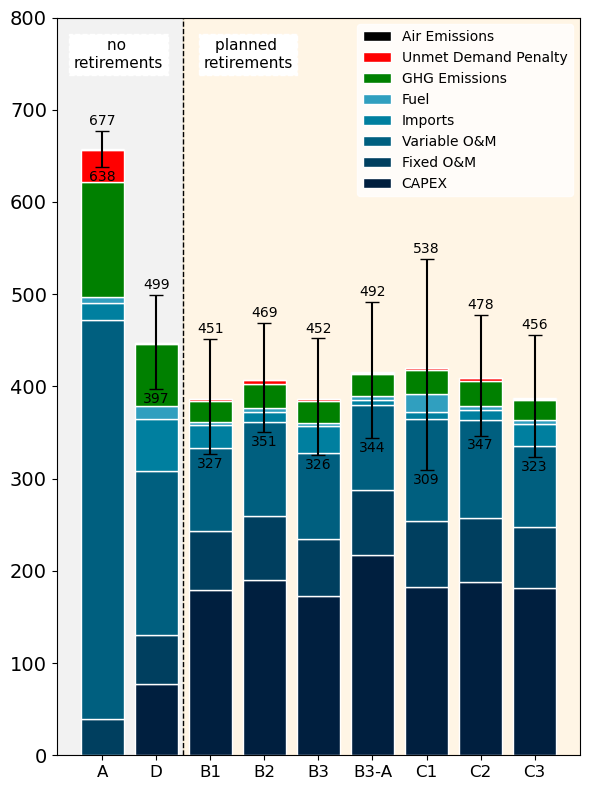

In [7]:
# Define the custom stacking order
stacking_order = [
    'CAPEX', 'Fixed O&M', 'Variable O&M', 'Imports', 
    'Fuel', 'GHG Emissions', 'Unmet Demand Penalty','Air Emissions'
]

# Prepare the data for the stacked bar plot
stacked_data = combined_ranges[combined_ranges['Statistic'] == 'mean']
stacked_data = stacked_data.pivot(index='Pathway', columns='Cost_Type', values='Cost_bUSD').fillna(0)

# Re-order columns based on stacking order
stacked_data = stacked_data[stacking_order]
stacked_data = stacked_data.loc[["D"] + [i for i in stacked_data.index if i != "D"]]
stacked_data = stacked_data.loc[["A"] + [i for i in stacked_data.index if i != "A"]]

# Define custom colors for each Cost_Type
custom_colors = {
    'Air Emissions': 'black',        # Pastel Blue
    'Unmet Demand Penalty': 'red',  # Lightest Pastel Blue
    'GHG Emissions': 'green',        # Light Sky Blue
    'Fuel': '#309fbf',                 # Soft Blue
    'Imports': '#007f9f',              # Muted Aquamarine
    'Variable O&M': '#005f7f',         # Teal Blue
    'Fixed O&M': '#003f5f',            # Dark Blue
    'CAPEX': '#001f3f'                 # Navy
}



# Map the colors to the stacking order
colors = [custom_colors[cost_type] for cost_type in stacking_order]

# Create the plot
plt.figure(figsize=(6, 8))

# Get the Axes object
ax = plt.gca()

# Plot stacked bars
for i, column in enumerate(stacked_data.columns):
    if i == 0:
        # First column, no shift needed for bottom
        bottom = 0
    else:
        # Subsequent columns, calculate bottom from cumulative sum
        bottom = stacked_data.iloc[:, :i].sum(axis=1)  # Sum all previous columns
    
    plt.bar(
        stacked_data.index,
        stacked_data[column],
        bottom=bottom,
        label=column,
        edgecolor="white",
        color=colors[i]
    )

# Add error bars for total costs
for i, pathway in enumerate(mean_costs['Pathway']):
    ymin = min_costs[min_costs['Pathway'] == pathway]['Total_Cost_bUSD'].values[0]
    ymax = max_costs[max_costs['Pathway'] == pathway]['Total_Cost_bUSD'].values[0]
    mean_cost = mean_costs[mean_costs['Pathway'] == pathway]['Total_Cost_bUSD'].values[0]
    offset = 3  # Adjust this value as needed for the desired spacing
     # Error bar
    plt.errorbar(
        x=pathway,
        y=mean_cost,
        yerr=[[mean_cost - ymin], [ymax - mean_cost]],
        fmt='none',
        ecolor='black',
        capsize=5
    )

    # Add annotations for max and min values with offsets
    plt.text(
        x=pathway,
        y=ymax + offset,  # Increase the y-position for the ymax text
        s=format_cost(ymax),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )
    plt.text(
        x=pathway,
        y=ymin - offset,  # Decrease the y-position for the ymin text
        s=format_cost(ymin),
        ha='center',
        va='top',
        fontsize=10,
        color='black'
    )


# Add horizontal line for y=0
plt.axvline(x=1.5, color="black", linewidth=1, linestyle="--")
plt.ylim(0, 800) 

# Add gray rectangles on the side or background as needed
# Adjust positions and dimensions for vertical layout
# Example coordinates for the rectangles
rect_width = 3  # Width of the rectangle
rect_height = 800  # Height spanning the y-axis

# First rectangle (e.g., "no retirements")
rect_x = -0.5  # Starting from the left of the first bar
rect_y = 0
ax.add_patch(
    plt.Rectangle(
        (rect_x-1, rect_y),
        rect_width,
        rect_height,
        color="gray",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)

# Second rectangle (e.g., "planned retirements")
ax.add_patch(
    plt.Rectangle(
        (rect_x+2, rect_y),  # Adjust as needed
        rect_width+5,
        rect_height,
        color="orange",
        alpha=0.1,
        zorder=-1,
        edgecolor=None  # No border
    )
)


# Add text boxes on the rectangles
plt.text(
    x=rect_x + rect_width - 2.2,  # Center of the rectangle
    y=rect_y + rect_height - 40,  # Adjust vertical position
    s="no \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

plt.text(
    x=rect_x + 3.2,  # Center of the rectangle
    y=rect_y + rect_height  - 40,  # Adjust vertical position
    s="planned \nretirements",  # Text content
    fontsize=11,  # Font size
    ha='center',  # Horizontal alignment
    va='center',
    bbox=dict(boxstyle='square', edgecolor='white', linestyle='--', facecolor='white')  # Styling
)

# Customize legend
#plt.legend(title="Cost_Type", fontsize=12, title_fontsize=14, loc='upper right')
# Get the handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of handles and labels
handles = handles[::-1]
labels = labels[::-1]

# Customize legend
plt.legend(
    handles, labels,             # Use the reversed handles and labels
    loc='upper right',           # Adjust legend position
    frameon=True,                # Add a border
    framealpha=0.8,              # Set border and background opacity
    fancybox=True,               # Rounded edges for the legend box
    edgecolor='white'            # Border color
)

# Adjust axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.savefig('Total_Costs.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import f_oneway, ttest_ind

unique_pathways = total_costs['Pathway'].unique()

# Perform pairwise t-tests for each pair of pathways
results = []
for i in range(len(unique_pathways)):
    for j in range(i + 1, len(unique_pathways)):
        pathway_1 = unique_pathways[i]
        pathway_2 = unique_pathways[j]

        # Filter data for the two pathways
        data1 = total_costs[total_costs['Pathway'] == pathway_1]['Total_Cost_bUSD']
        data2 = total_costs[total_costs['Pathway'] == pathway_2]['Total_Cost_bUSD']

        # Perform t-test
        t_stat, p_value = ttest_ind(data1, data2)

        # Store results
        results.append({
            'Pathway_1': pathway_1,
            'Pathway_2': pathway_2,
            't_stat': t_stat,
            'p_value': p_value
        })

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Display significant results (e.g., p-value < 0.05)
significant_results = results_df[results_df['p_value'] < 0.05]
significant_results

,Pathway_1,Pathway_2,t_stat,p_value
0,A,B1,7.145493,0.002029
1,A,B2,6.917516,0.002292
2,A,B3,7.056870,0.002127
3,A,B3-A,5.436118,0.005557
4,A,C1,3.510019,0.024671
5,A,C2,6.243535,0.003354
6,A,C3,6.731519,0.002537
7,A,D,6.653028,0.002651
